# COMP47750
# Machine Learning with Python

## Assignment 2
## Pipelines, Feature Selection


### Daniel Cosgrave - 16302163

In [1]:
#Imports and Definitions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from collections import Counter
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline as imbPipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#def predictivity_score(test,pred,cl):  return Counter(pred)[cl]/Counter(test)[cl]
def predictivity_score(test,pred,cl):  return 1-np.abs(Counter(pred)[cl]-Counter(test)[cl])/(Counter(test)[cl])

# Task 1 Bias Reduction With Cross Validation

## Comparison of Survival Dataset using Hold-Out-Testing and Cross Validation

For this task I repeated my analysis from the previous assignment. I split the training and test data 70/30 and used
a SMOTE and Edited Nearest Neighbours Strategy to Resample the minority and majority class datasets.
Along with a standard scaler transform for data normalization fitted to the training data

Note: In the previous task I used a metric to consider the bias of my classifiers.
The ratio of the minority class in the predicted and test sets
i.e.

\begin{equation*}
Measure   = \frac{Minority\;Class\;Predicted}{Minority\;Class\;Test\;Set}
\end{equation*}

I called this measure 'Relative Minority Class Prediction' which is a bit clunky to write.
For this assignment I will arbitrarily refer to it as 'Predictivity', and came up with
the general idea for it

The 'predictivity' of the classifier, is the relative predictive ability of the classifier
for a particular class, to the test set. I have included a scorer function above called
predictivity_score

I later changed the measure to be defined as the inverse of the error between the two.
I was getting results that were difficult to compare since the result could be greater than 100%
i.e.

\begin{equation*}
Predictivity = 1 - \frac{| Predicted \; Class - Reference \; Class|}{Reference \;Class}
\end{equation*}


This means that though some information is lost like which direction the classifier is biased in (+-)
but it is much easier to use as a scorer and to compare with the other metrics.

In [2]:
#Import Dataset and apply standard scaling

surv = pd.read_csv('survival.csv')
surv.head()
y = surv.pop('Class').values
X = surv.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=3554)

#Create a training set scaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
#Scale the test set
X_test = scaler.transform(X_test)

In [3]:
#Data Pre-Processing

smt = SMOTEENN(random_state=3554,sampling_strategy='auto', n_jobs=-1)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

## Classifiers
I repeated the classifiers from the initial set of classifiers in assignment 1 using mostly default settings.

>Nearest Neighbours (3)
>
>Decision Tree (entropy)
>
>Logistic Regression
>
>Gradient Boosting (20 trees)

In [4]:
#Pipeline Classifiers

names = ["Nearest Neighbors",
         "Decision Tree",
         "Logistic Regression",
         "Gradient Boosting"]

classifiers = [
    KNeighborsClassifier(n_neighbors=2, weights='distance'),
    DecisionTreeClassifier(max_depth=None, criterion = 'entropy'),
    LogisticRegression(),
    GradientBoostingClassifier(n_estimators=20,max_depth=None)]

clf = list(zip(names,classifiers))

### Hold-Out

In [5]:
#Pipeline Classifiers HO Test

aocScore = []
Predictivity = []
accuracy = []
test_neg = Counter(y_test)[2]
print('Test Set Minority Count:',  Counter(y_test)[2], '(',Counter(y_test)[2]/len(y_test),')')
#Train on scaled data, test on unscaled data
i = 0
for name, classifier in clf:
    #test on completely unseen data that has not been smt sampled
    y_pred = classifier.fit(X_smt, y_smt).predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred)*100)
    aocScore.append(roc_auc_score(y_test,y_pred)*100)
    Predictivity.append(predictivity_score(y_test,y_pred,2)*100)
    print(name, ' minority prediction: ', Counter(y_pred)[2], '(', Counter(y_pred)[2]/len(y_pred), ')')
    i = i + 1

Test Set Minority Count: 33 ( 0.358695652173913 )
Nearest Neighbors  minority prediction:  36 ( 0.391304347826087 )
Decision Tree  minority prediction:  39 ( 0.42391304347826086 )
Logistic Regression  minority prediction:  39 ( 0.42391304347826086 )
Gradient Boosting  minority prediction:  42 ( 0.45652173913043476 )


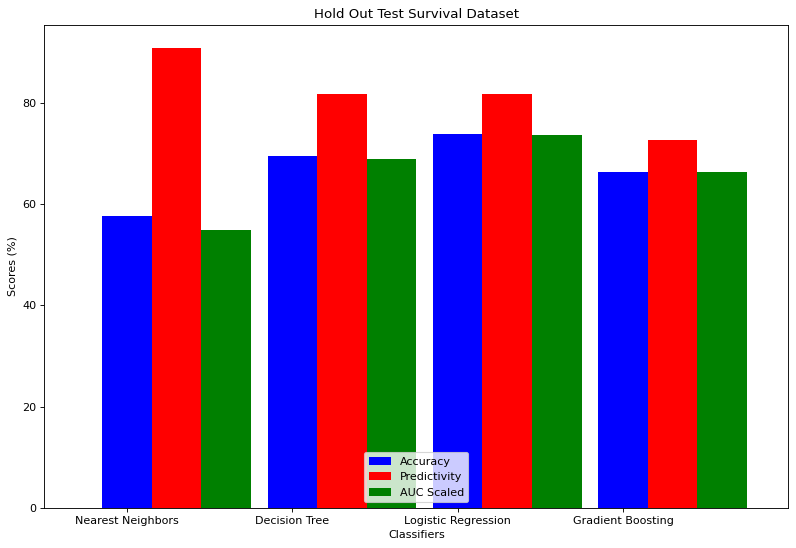

<Figure size 432x288 with 0 Axes>

In [6]:
#Bar Charts

N = len(classifiers)

Nrange = np.arange(N)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
width = 0.3
plt.bar(Nrange, accuracy, width, label = names,color = 'blue')
plt.bar(Nrange+width, Predictivity, width, label = names, color = 'red')
plt.bar(Nrange+2*width, aocScore, width, label = names, color = 'green')
plt.legend(['Accuracy','Predictivity', 'AUC Scaled' ],loc='lower center')
plt.xlim([-0.5,N])
plt.xlabel('Classifiers')
plt.ylabel('Scores (%)')
plt.title('Hold Out Test Survival Dataset')
plt.xticks(Nrange, names)
plt.show()
plt.tight_layout()

#### Results
The relative results were mostly the same for any train/test split, though the overestimation of
the resampled minority class reached up to 160% in some splits. I am presenting what I found to be a
split that is mostly representative of the others.

The bias of the classifier is low, in-fact the classifier over-estimates the minority class by up to 10%, though
accuracy is between 60 and 70%.

### Cross Validation

In [7]:
#Pipeline Classifiers CV

aocScore = []
Predictivity = []
accuracy = []
test_neg = Counter(y)[2]
testCl = test_neg/len(y)
print('Data Set Minority Count:', test_neg, '(',testCl,')')
i = 0
for name, classifier in clf:
    pl = imbPipeline([
                    #apply scaling per cv split (the previous
                    #scaling is only applied to the split data
                    #which is not used here)
                    ('scaler',StandardScaler()),
                    ('smt',SMOTEENN(random_state=3554,sampling_strategy='auto', n_jobs=-1)),
                    ('clf',classifier)
                    ])
    #test on completely unseen data that has not been smt sampled
    y_pred = cross_val_predict(pl,X, y,cv=12)
    accuracy.append(accuracy_score(y, y_pred)*100)
    aocScore.append(roc_auc_score(y,y_pred)*100)
    Predictivity.append(predictivity_score(y,y_pred,2)*100)
    print(name, ' minority prediction: ', Counter(y_pred)[2], '(', Counter(y_pred)[2]/len(y_pred), ')')
    i = i + 1

Data Set Minority Count: 81 ( 0.2647058823529412 )
Nearest Neighbors  minority prediction:  111 ( 0.3627450980392157 )
Decision Tree  minority prediction:  115 ( 0.3758169934640523 )
Logistic Regression  minority prediction:  112 ( 0.3660130718954248 )
Gradient Boosting  minority prediction:  117 ( 0.38235294117647056 )


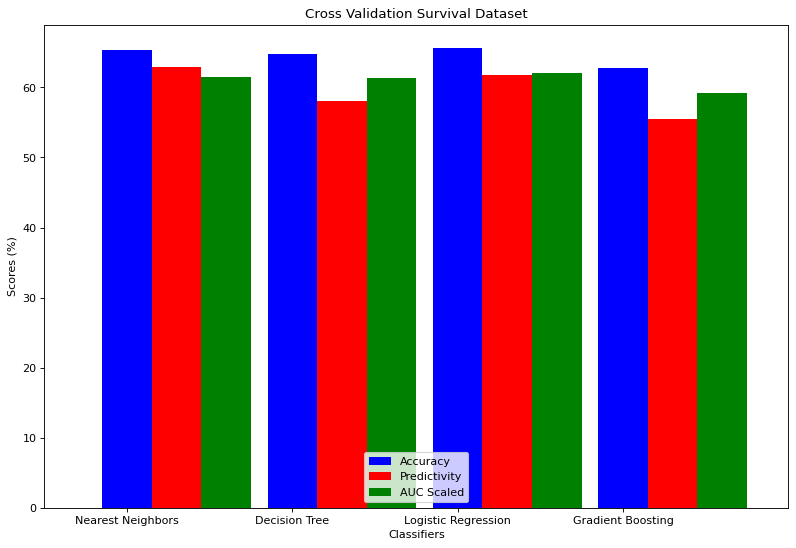

<Figure size 432x288 with 0 Axes>

In [8]:
#Bar Charts

N = len(classifiers)
Nrange = np.arange(N)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
width = 0.3
plt.bar(Nrange, accuracy, width, label = names,color = 'blue')
plt.bar(Nrange+width, Predictivity, width, label = names, color = 'red')
plt.bar(Nrange+2*width, aocScore, width, label = names, color = 'green')
plt.legend(['Accuracy','Predictivity', 'AUC Scaled' ],loc='lower center')
plt.xlim([-0.5,N])
plt.xlabel('Classifiers')
plt.ylabel('Scores (%)')
plt.title('Cross Validation Survival Dataset')
plt.xticks(Nrange, names)
plt.show()
plt.tight_layout()

#### Results

Cross Validation has evened out the results of the classifiers, they are all performing
about the same, with 60% classification and 0.6-0.65 AUC. This shows that even with cross
validation there is a a problem with accuracy when resampling the data. The worse results
with cross validation may be due to some cross validation folds resulting in very poor
results, and some resulting in much better ones, especially for nearest neighbours which 
did quite poorly in the hold-out test. Cross Validation has also shifted the results
even more steeply towards being biased to the minority class.

# Task 2

In this section I compare an information gain filter with a forward feature selection,
wrapper along with parameter tuning to get the best possible single classifier for the
heart dataset.

The data is pre-split into training and test, and the minority class in the training set
is more highly represented in the training set, therefore we should expect quite different
results when we do cross validation on just the training set, and hold-out on the split.



In [9]:
#Loading Data Part 2

heart = pd.read_csv('heart-train.csv')
heart['DEATH_EVENT'].value_counts()
y_train = heart.pop('DEATH_EVENT').values
X_train = heart.values

heartTest = pd.read_csv('heart-test.csv')
y_test = heartTest.pop('DEATH_EVENT').values
X_test = heartTest.values

MinorityClass = (Counter(y_train)[1]/len(y_train))
MinorityClassTest = (Counter(y_test)[1]/len(y_train))

print("Minority class Training Set : %0.2f" %MinorityClass)
print("Minority class Test Set : %0.2f" %MinorityClassTest)

Minority class Training Set : 0.32
Minority class Test Set : 0.16


#### Baseline

In [10]:
#Basic Classifier

clf = GradientBoostingClassifier()

In [11]:
y_pred = clf.fit(X_train, y_train).predict(X_test)
accuracyB = accuracy_score(y_test, y_pred)*100
aocScoreB = roc_auc_score(y_test,y_pred)
predictivityB = predictivity_score(y_test,y_pred,1)*100
print('Baseline Hold out test Accuracy: ', accuracyB,
      '%% Min Predictivity:  %0.2f' %predictivityB,
      '%% AUC: %0.2f' %aocScoreB)

Baseline Hold out test Accuracy:  82.0 % Min Predictivity:  93.75 % AUC: 0.78


In [12]:
#Baseline CV

y_pred = cross_val_predict(clf,X_train, y_train,cv = 12)
accuracyCVB = accuracy_score(y_train, y_pred)*100
aocScoreCVB = roc_auc_score(y_train,y_pred)
predictivityCVB = predictivity_score(y_train,y_pred,1)*100
print('Baseline Cross Validation Accuracy: ', accuracyCVB,
      '%% Min Predictivity:  %0.2f' %predictivityCVB,
      '%% AUC: %0.2f' %aocScoreCVB)

Baseline Cross Validation Accuracy:  81.90954773869346 % Min Predictivity:  90.62 % AUC: 0.78


#### Paramater Tuning

The basic gradient boosting classifier does a quite a good job, we can fine tune its performance with
parameter tuning to get the most out of the full dataset

I used grid-search cross validation to tune the parameters on the training data,
specifically for the ROC AUC metric, the area under the true positive rate, false positive
rate curve, which is a useful metric for determining how accurate the classifier is when
it classifies a value as either class. This is one of the best metrics for identifying
biased classifiers, as it can identify if the classifier is blindly choosing the majority class

In [13]:
#Paramater Tuning (Only run once)

# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 10),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 10),
#     "max_depth":[3,5,8,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":[10,20,None]
#     }
#
# scoring = {'accuracy': make_scorer(accuracy_score),
#            'predictivity':  make_scorer(predictivity_score,cl=1),
#            'AUC': make_scorer(roc_auc_score)}
#
# #passing the scoring function in the GridSearchCV
# clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)
# clf.fit(X_train, y_train)
# df=pd.DataFrame.from_dict(clf.cv_results_)

In [14]:
# df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2
# df.loc[df['accuracy_score'].idxmax()]['params']

In [15]:
# df['predictivity_score']=(df['split0_test_predictivity']+df['split1_test_predictivity'])/2
# df.loc[df['predictivity_score'].idxmax()]['params']

In [16]:
# df['roc_auc_score']=(df['split0_test_AUC']+df['split1_test_AUC'])/2
# df.loc[df['roc_auc_score'].idxmax()]['params']

Gridsearch takes a while to run so these are the resulting paramaters tuned for accuracy, predictivity,
and AUC, while I have commented out the gridsearch code so it doesn't slow down every iteration.

In [17]:
#Gradient Boosting Classifier Parameter Tuned

#accuracy
clf = GradientBoostingClassifier(criterion = 'friedman_mse',
                                 learning_rate= 0.2,
                                 loss= 'deviance',
                                 max_depth= 5,
                                 max_features= 'sqrt',
                                 min_samples_leaf= 0.1889,
                                 min_samples_split= 0.4556,
                                 n_estimators= 20,
                                 subsample= 1)
#predictivity
# clf = GradientBoostingClassifier(criterion = 'mae',
#                                  learning_rate= 0.2,
#                                  loss= 'deviance',
#                                  max_depth= 5,
#                                  max_features= 'sqrt',
#                                  min_samples_leaf= 0.1,
#                                  min_samples_split= 0.3667,
#                                  n_estimators= 20,
#                                  subsample= 0.95)
#auc
# clf = GradientBoostingClassifier(criterion = 'friedman_mse',
#                                  learning_rate= 0.2,
#                                  loss= 'deviance',
#                                  max_depth= 3,
#                                  max_features= 'sqrt',
#                                  min_samples_leaf= 0.1444,
#                                  min_samples_split= 0.4556,
#                                  n_estimators= 20,
#                                  subsample= 0.8)

#### Baseline with parameter tuning

I tested the paramaters tuned for each metric and decided on accuracy for this comparison.
Paramater tuning can help get the best out of the data we have.

In [18]:
#Tuned HO Test

#clf = GradientBoostingClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
accuracyT = accuracy_score(y_test, y_pred)*100
aocScoreT = roc_auc_score(y_test,y_pred)
predictivityT = predictivity_score(y_test,y_pred,1)*100
print('Paramater Tuned Hold out test Accuracy: %0.2f' %accuracyT,
      '%% Min Predictivity:  %0.2f' %predictivityT,
      '%% AUC: %0.2f' %aocScoreT)

Paramater Tuned Hold out test Accuracy: 87.00 % Min Predictivity:  78.12 % AUC: 0.82


In [19]:
#Tuned CV

y_pred = cross_val_predict(clf,X_train, y_train,cv = 12)
accuracyCVT = accuracy_score(y_train, y_pred)*100
aocScoreCVT = roc_auc_score(y_train,y_pred)
predictivityCVT = predictivity_score(y_train,y_pred,1)*100
print('Parameter Tuned Cross Validation Accuracy: %0.2f' %accuracyCVT,
      '%% Min Predictivity:  %0.2f' %predictivityCVT,
      '%% AUC: %0.2f' %aocScoreCVT)

Parameter Tuned Cross Validation Accuracy: 82.91 % Min Predictivity:  84.38 % AUC: 0.78


The results of the tuned paramaters see improvements in the accuracy and AUC performance,
though there was a small trade-off in the predictivity (bias) of the classifier in hold-out, and a large bias
trade-off in cross validation. Using cross validation in this case is a stable
way of assessing the data, however the dataset is smaller and therefore harder to compare to
the combined train/test set, since the amount of data available is already quite little.

Paramater tuning greatly improved the CV performance though it made the classifier less
prdictive of the minority class

## Feature Selection - Information Gain Filter
The information gain filter is a little unstable in the features it selects,
 even with a random state set, but finding a good combination can improve the results of the
 tuned classifier

In [20]:
#Information Gain

i_scores = mutual_info_classif(X_train,y_train, random_state = 3554)

FS_DF = pd.DataFrame(i_scores,index = heart.columns, columns =['I-Gain'])
FS_DF.sort_values(by=['I-Gain'],ascending=False,inplace=True)
FS_DF

igvals = FS_DF['I-Gain']
print(igvals)


time                        0.227980
ejection_fraction           0.114754
serum_creatinine            0.074379
age                         0.073536
anaemia                     0.030343
smoking                     0.027791
diabetes                    0.025873
serum_sodium                0.017112
high_blood_pressure         0.015039
creatinine_phosphokinase    0.003523
platelets                   0.000000
sex                         0.000000
Name: I-Gain, dtype: float64


In [21]:
#Information Gain DF

#filter feature selection
igDex = 1
accuracy = []
aocScore = []
Predictivity = []
test_neg = Counter(y_test)[1]
for i in igvals: #cycle through the features ranked by IG
    top_DF = heart[FS_DF.index[:igDex]]
    top_DF = heart[FS_DF.index[:igDex]]
    top_test_DF = heartTest[FS_DF.index[:igDex]]
    X_test_top = top_test_DF.values
    X_top = top_DF.values

    y_pred = clf.fit(X_top, y_train).predict(X_test_top)
    accuracy.append(accuracy_score(y_test, y_pred))
    aocScore.append(roc_auc_score(y_test,y_pred))
    Predictivity.append(predictivity_score(y_test,y_pred,1))
    igDex += 1

top_DF = heart[FS_DF.index[:igDex]]
top_DF = heart[FS_DF.index[:igDex]]
top_test_DF = heartTest[FS_DF.index[:igDex]]
X_test_top = top_test_DF.values
X_top = top_DF.values

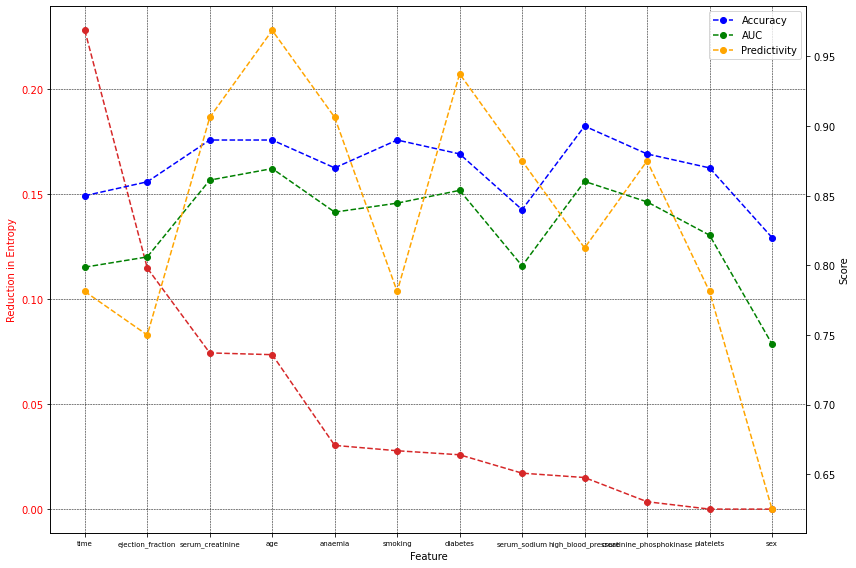

In [22]:
 #Plotting IG values and inference

#ax1
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.set_xlabel('Feature')
ax1.set_ylabel('Reduction in Entropy', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.plot(igvals,'o--',color = 'tab:red')
ax1.tick_params(axis='x', which='major', labelsize=7)
ax1.grid(color='black', linestyle='--', linewidth=0.5)
#ax2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Score', color='black')  # we already handled the x-label with ax1
ax2.plot(accuracy,'o--', color='blue')
ax2.plot(aocScore,'o--', color='green')
ax2.plot(Predictivity,'o--', color='orange')
ax2.tick_params(axis='y', labelcolor='black')
fig.tight_layout()
plt.legend(['Accuracy','AUC', 'Predictivity' ])
plt.show()


#### Information Gain Filter Optimal features

We can see from the graph that there is 4-7 features seems to be the
optimal number for this dataset, accounting for the instability of
the filter.

In [23]:
#Information Gain Selection
igDex = np.argmax(accuracy) #index of highest accuracy subset
print('Accuracy Optimised k Features: ', igDex)
top_DF = heart[FS_DF.index[:igDex]]
top_DF = heart[FS_DF.index[:igDex]]
top_test_DF = heartTest[FS_DF.index[:igDex]]
X_test_top = top_test_DF.values
X_top = top_DF.values

Accuracy Optimised k Features:  8


In [24]:
#Information Gain HO Test

y_pred = clf.fit(X_top, y_train).predict(X_test_top)
accuracyIG = (accuracy_score(y_test, y_pred))*100
aocScoreIG = (roc_auc_score(y_test,y_pred))
predictivityIG = predictivity_score(y_test,y_pred,1)*100

print('IG Hold out test Accuracy: %0.2f' %accuracyIG,
      '%% Min Predictivity:  %0.2f' %predictivityIG,
      '%% AUC: %0.2f' %aocScoreIG)

IG Hold out test Accuracy: 88.00 % Min Predictivity:  75.00 % AUC: 0.83


## Feature Selection - Forward Search Wrapper

I compared the filter feature selection with a forward search wrapper, and
found the results comparable with the information gain filter. The difficulty with the wrapper in this scenario is that the results are all fairly stable, so it is difficult for it to discern the best mix of features.

In [25]:
 #Forward Sequential Feature Selection

#look at all the features together
sfsV = SFS(clf,
                  k_features=12,
                  forward=True,
                  floating=False,
                  verbose=0,
                  scoring='accuracy',
                  cv=12, n_jobs = -1)

sfsV = sfsV.fit(X_train, y_train,custom_feature_names=heart.columns)

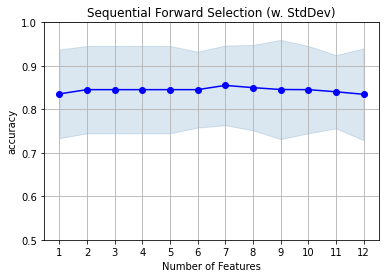

In [26]:
#Forward Search Plot

fig1 = plot_sfs(sfsV.get_metric_dict(),
                ylabel='accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [27]:
 #Forward Search k Features

#find the best k features
sfsV = SFS(clf,
                  k_features=6,
                  forward=True,
                  floating=False,
                  scoring='accuracy',
                  cv=12, n_jobs = -1)

#Fit on training data
sfsV = sfsV.fit(X_train, y_train,custom_feature_names=heart.columns)
b5_feat = sfsV.k_feature_names_
print('best k features:',b5_feat)

best k features: ('age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_sodium', 'sex', 'time')


In [28]:
#Data Transformation

X_train_sfs = sfsV.transform(X_train)
#Use fitted model on test data to match train features
X_test_sfs = sfsV.transform(X_test)

In [29]:
#Forward Search HO Test

y_pred = clf.fit(X_train_sfs, y_train).predict(X_test_sfs)
accuracySFS = accuracy_score(y_test, y_pred)*100
aocScoreSFS = roc_auc_score(y_test,y_pred)
predictivitySFS = predictivity_score(y_test,y_pred,1)*100

print('SFS Hold out test Accuracy: %0.2f' %accuracySFS,
      '%% Min Predictivity:  %0.2f' %predictivitySFS,
      '%% AUC: %0.2f' %aocScoreSFS)

SFS Hold out test Accuracy: 86.00 % Min Predictivity:  81.25 % AUC: 0.81


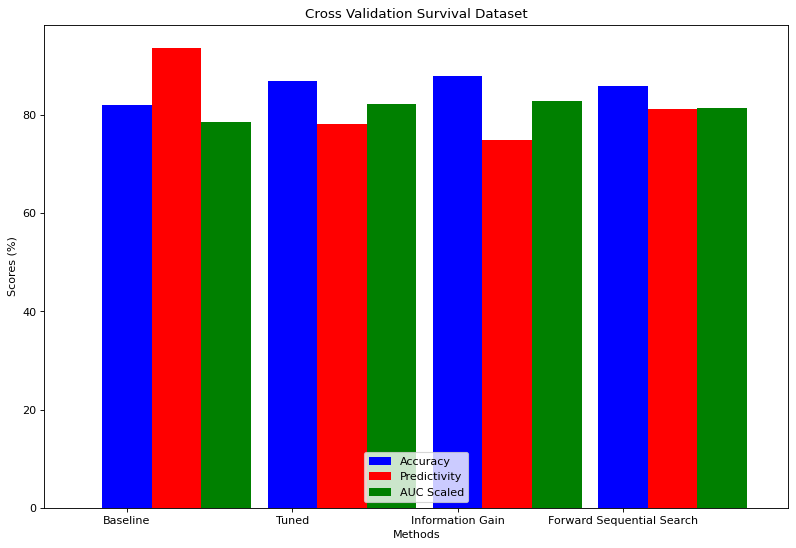

<Figure size 432x288 with 0 Axes>

In [30]:
#Comparison Bar Chart

accuracy = [accuracyB,accuracyT,accuracyIG,accuracySFS]
predictivity = [predictivityB,predictivityT,predictivityIG,predictivitySFS]
aocScore = [aocScoreB*100,aocScoreT*100,aocScoreIG*100,aocScoreSFS*100]
N = len(accuracy)
Nrange = np.arange(N)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
width = 0.3
plt.bar(Nrange, accuracy, width, label = names,color = 'blue')
plt.bar(Nrange+width, predictivity, width, label = names, color = 'red')
plt.bar(Nrange+2*width, aocScore, width, label = names, color = 'green')
plt.legend(['Accuracy','Predictivity', 'AUC Scaled' ],loc='lower center')
plt.xlim([-0.5,N])
plt.xlabel('Methods')
plt.ylabel('Scores (%)')
plt.title('Cross Validation Survival Dataset')
plt.xticks(Nrange, ['Baseline','Tuned','Information Gain', 'Forward Sequential Search' ])
plt.show()
plt.tight_layout()

# Conclusion

The baseline gradient boosting classifier achieved accuracy of above 80%
and strong performance overall. The and performance can be tweaked upwards by
some parameter tuning using grid-search.

The performance can be improved by using a feature selection wrapper or filter
Both of these provide quite similar performance, though the features selected
are easier to control with the filter method, as the dataset is small and the
difference between the best performing and the worst performing configuration 
is very small.

The lack of data available does result in some instability in the performance.